A code to create a neural network from scratch, using only numpy. This network is very customizable. There is also a bit at the end which uses the network as an autoencoder. The dataset used in this code is MNIST, but it works with any.

If you have any questions, please let me know and I'd be happy to answer them.

Thanks, Manvik

# Imports

some imports and pip installs we need

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install python-mnist

In [ ]:
from mlxtend.data import loadlocal_mnist
import numpy as np
from tqdm import tqdm

# Data

getting the mnist dataset (training and testing sets) from the ubyte file we have already downloaded

In [ ]:
X, y = loadlocal_mnist(
  images_path='/content/drive/MyDrive/archive/train-images.idx3-ubyte',
  labels_path='/content/drive/MyDrive/archive/train-labels.idx1-ubyte'
)

# normalizing pixel values from 0-255 to 0-1
X = X / 255

In [ ]:
# there are 60000 images in the training set,
# which will be very slow to work with,
# so, this is a shortened version

X_small = X[0:1000][:]
y_small = y[0:1000][:]
X_small.shape

(1000, 784)

In [ ]:
X_test, y_test = loadlocal_mnist(
  images_path='/content/drive/MyDrive/archive/t10k-images.idx3-ubyte',
  labels_path='/content/drive/MyDrive/archive/t10k-labels.idx1-ubyte'
)

# normalizing pixel values from 0-255 to 0-1
X_test = X_test / 255

# Functions

creation of necessary functions and classes

In [ ]:
# visualizes an image stored as 784-vector
# with values from 0-1 as a 28 by 28
# grayscaled image

from matplotlib import pyplot as plt
def visualize(image):
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()

In [ ]:
# creating a layer class, which represents
# a single neural network layer

class Layer:
  def __init__(self, input, output, lam=0.001, activation=None, regularizer="l2", dropout_rate=0.1, random_state=23):
    np.random.seed(random_state) # setting a random seed to initial weights and biases are same
    self.input = input # setting the input size of layer
    self.output = output # setting output size of layer
    self.weights = (np.random.rand(input, output) - 0.5) / 100 # initializing weights to be random values
    self.bias = (np.random.rand(output) - 0.5) / 100 # initializing bias to be random values
    self.lam = lam # setting lambda regularization value
    self.activation = activation # setting which activation to use (relu, sigmoid, tanh, softmax, or none)
    self.regularization = regularizer # choosing which regularizer to use (l2 or none)
    self.dropout_rate = dropout_rate # setting dropout rate

  def __str__(self):
    return "Input Size: " + str(self.input) + ", Output Size: " + str(self.output) + ", Activation: " + str(self.activation)

  def getInputSize(self):
    return self.input

  def getOutputSize(self):
    return self.output

  def forward(self, X):
    # performs a matrix multiplication
    # to multiply weights by input
    # and add bias as well
    # returning y = WX + B

    return X.dot(self.weights) + self.bias

  def l2(self, n):
    # returns value for l2 regularization loss

    return (self.lam / n) * ((self.weights ** 2).sum() + (self.bias ** 2).sum())

  def d_l2(self, n, to_do):
    # returns derivative for l2 regularization loss

    return 2 * (self.lam / n) * (to_do.sum(axis=0))

  def regularizer(self, n):
    # used to get the regularization value

    if self.regularization == "l2":
      return self.l2(n)
    elif self.regularization == None:
      return 0

  def d_regularizer(self, X, to_do):
    # used to get derivative or regularization value

    if self.regularization == "l2":
      return self.d_l2(X, to_do)
    elif self.regularization == None:
      return 0

  def ReLU(self, x):
    # returns the relu value (x if x > 0 and 0 if x <= 0)

    return x * (x > 0)

  def d_ReLU(self, x):
    # returns derivative of relu (1 if x > 0 and 0 if x <= 0)

    return x > 0

  def sigmoid(self, x):
    # returns sigmoid value

    return (1 / (1 + np.exp(-1 * x)))

  def d_sigmoid(self, x):
    # returns derivative of sigmoid

    return self.sigmoid(x) * (1 - self.sigmoid(x))

  def tanh(self, x):
    # returns tanh value

    return np.tanh(x)

  def d_tanh(self, x):
    # returns derivative of tanh value

    return 1 - np.tanh(x) ** 2

  def softmax(self, x):
    # returns softmax value, and
    # no derivative bc you have to
    # use cross entropy as loss function
    # and this has to be last layer

    shiftx = x - np.max(x) # normalizes values to make computation easier
    return np.exp(shiftx)/np.sum(np.exp(shiftx))

  def activate(self, X):
    # used to get value from activation function

    if self.activation == None:
      return X
    elif self.activation == "ReLU":
      return self.ReLU(X)
    elif self.activation == "sigmoid":
      return self.sigmoid(X)
    elif self.activation == "tanh":
      return self.tanh(X)
    elif self.activation == "softmax":
      return self.softmax(X)

  def d_activate(self, X):
    # used to get derivative from activation function

    if self.activation == None:
      return 1
    elif self.activation == "ReLU":
      return self.d_ReLU(X)
    elif self.activation == "sigmoid":
      return self.d_sigmoid(X)
    elif self.activation == "tanh":
      return self.d_tanh(X)
    elif self.activation == "softmax":
      return 1 # 1 isn't actually the derivative, but we choose use the cross entropy one (it's nicer math)

  def backwards(self, next_d, previous, lr):
    # performs backpropagation
    # to update the weights, which
    # consists of using chain rule
    # to find derivative of weights
    # and bias with respect to error

    pred = self.forward(previous) # gets the output from this layer
    n = previous.shape[0] # gets the batch size

    # calculates the error, which is just
    # previous derivative times activation
    # function derivative, and if it is last
    # layer then previous derivative is just
    # derivative of loss function, and we use
    # previous derivative bc chain rule
    error = self.d_activate(pred) * next_d


    weights_gradient = lr * (previous.T.dot(error) * (1/n) + self.d_regularizer(n, self.weights)) # finding the weights gradient, with learning rate (lr) showing how quickly to update
    bias_gradient = lr * (np.mean((error), axis=0) *  (1/n) + self.d_regularizer(n, self.bias)) # finding bias gradient, with learning rate (lr) showing how quickly to update

    return_thing = error.dot(self.weights.T) # getting the derivative to pass on to the layer behind this one

    self.weights -= weights_gradient # updating weights with gradient descent
    self.bias -= bias_gradient # updating bias with gradient descent

    return return_thing

In [ ]:
class Network:
  def __init__(self, loss_fn="mse"):
    self.layers = [] # the layers are stored as a list
    self.loss_fn = loss_fn # loss function you want to use (mse or cross_entropy)

  def __str__(self):
    return "\n".join(["Layer #" + str(x+1) + ": " + self.layers[x].__str__() for x in range(len(self.layers))])

  def add(self, layer):
    self.layers.append(layer) # used to add a layer object to the network

  def remove(self):
    self.layers.pop() # used to remove the last layer from the network

  def one_hot(self, y):
    # performs one-hot encoding, which
    # converts a single integer to a list
    # of 1's and 0's, where 1's represent
    # the single integer taken in as input

    # if vector is input, returns a matrix
    # after doing above process for every value
    # in the vector

    num_cols = self.layers[len(self.layers)-1].getOutputSize()

    if type(y) == np.uint8:
      y = [y]

    one_hotted = []
    for value in list(y):
      temp = np.zeros(num_cols)
      temp[value] = 1
      one_hotted.append(temp)
    return np.array(one_hotted)

  def forward(self, X):
    # performs a forward pass through
    # the model, where the first layer's
    # input is the input and every following
    # layer's input is the output of its
    # previous layer

    previous = X
    for layer in self.layers:
      previous = layer.activate(layer.forward(previous))
    return previous

  def get_forward_outputs(self, X):
    # returns a list storing each layer's
    # output for an input of X

    previous = X.copy()
    output = []
    for layer in self.layers:
      output.append(previous)
      previous = layer.activate(layer.forward(previous))
    return output

  def get_regularizer(self, X):
    # sums up the regularizer loss for all
    # layers, which is then added to the loss

    previous = X
    reg = 0
    for layer in self.layers:
      reg += layer.regularizer(previous.shape[0])
      previous = layer.activate(layer.forward(previous))
    return reg

  def cross_entropy(self, pred, y):
    # finds cross entropy loss

    return np.sum((-1 * y * np.log(pred)), axis=1).mean()

  def d_cross_entropy(self, pred, y):
    # finds derivative of cross entropy
    # and softmax, since cross entropy
    # requires softmax anyways and by
    # combining the computation is nicer

    return pred - y

  def mse(self, pred, y):
    # finds mse loss

    return ((pred - y) ** 2).mean(axis=1).mean()

  def d_mse(self, pred, y):
    # finds derivative of mse loss

    return (pred - y)

  def loss(self, X, y, one_hot):
    # calculates the loss for the network's
    # prediction and a one-hot encoded label

    pred = self.forward(X)
    label = y
    if one_hot:
      label = self.one_hot(y)
    if self.loss_fn == "mse":
      return self.mse(pred, label) + self.get_regularizer(X)
    elif self.loss_fn == "cross_entropy":
      return self.cross_entropy(pred, label) + self.get_regularizer(X)

  def d_loss(self, X, y, one_hot):
    # calculates the derivative of the
    # loss for the network's prediction
    # and a one-hot encoded label

    pred = self.forward(X)
    label = y
    if one_hot:
      label = self.one_hot(y)

    if self.loss_fn == "mse":
      return self.d_mse(pred, label)
    elif self.loss_fn == "cross_entropy":
      return self.d_cross_entropy(pred, label)

  def backwards(self, X, y, lr, one_hot):
    # performs backpropagation for every layer
    # in the model, and uses derivative of loss
    # function for the first error

    next_d = self.d_loss(X, y, one_hot)
    previous_list = self.get_forward_outputs(X)

    for layer_id in range(len(self.layers)-1, -1, -1):
      next_d = (self.layers[layer_id]).backwards(next_d, previous_list[layer_id], lr)

  def train(self, X, y, X_test=None, y_test=None, epochs=500, lr=0.001, batch_size=256, verbose=2, early_stopping={"delta":0, "epochs":10, "to_do":"loss"}, one_hot=True, calculate_accuracy=True):
    # trains the network on data X and
    # labels y, with a bunch of extra features
    # which makes the code very long

    # here is a very concise and barebones
    # version, which should get the job done
    '''
    for epoch in range(epochs):
      self.backwards(X, y, lr)
      loss = self.loss(X, y)

      print("epoch: " + str(epoch) + ", Train Loss: " + str(loss))
    '''
    if verbose > 1 and (type(X_test) == type(None) or type(y_test) == type(None)):
      print("If verbose is greater than 1 then inputs and labels for a validation dataset must also be passed in")
    elif early_stopping["epochs"] < 0:
      print("Early Stopping Epochs must be less than 0")
    elif early_stopping["epochs"] > 0 and (type(X_test) == type(None) or type(y_test) == type(None)):
      print("Early Stopping needs validation data")
    elif self.loss_fn == "cross_entropy" and self.layers[len(self.layers)-1].activation != "softmax":
      print("Cross Entropy Loss Function requires use of softmax in the last layer")
    elif sum([self.layers[x].activation == "softmax" for x in range(len(self.layers)-2)]) > 0:
      print("Softmax can only be used on the last layer")
    elif calculate_accuracy and early_stopping["to_do"] == "accuracy":
      print("Bro you said not to calculate accuracy but you also told early stopping to do it")
    else:
      last_best = None
      epochs_since_change = 0

      for epoch in range(epochs):
        loss = []
        for batch in tqdm(range(0, X.shape[0], batch_size)):
          temp_X = X[batch:batch+batch_size]
          temp_y = y[batch:batch+batch_size]

          self.backwards(temp_X, temp_y, lr, one_hot)
          if verbose > 0:
            loss.append(self.loss(temp_X, temp_y, one_hot))

        if X.shape[0] % batch_size != 0:
          end_batch = (X.shape[0] // batch_size) * batch_size
          temp_X = X[end_batch:]
          temp_y = y[end_batch:]

          self.backwards(temp_X, temp_y, lr, one_hot)
          if verbose > 0:
            loss.append(self.loss(temp_X, temp_y, one_hot))

        if verbose > 0:
          loss = np.mean(loss)
          accuracy = None
          if calculate_accuracy:
            accuracy = self.test(X, y)
          if verbose > 1:
            test_accuracy = None
            if calculate_accuracy:
              test_accuracy = self.test(X_test, y_test)
            test_loss = self.loss(X_test, y_test, one_hot)
            if calculate_accuracy:
              print("Epoch: " + str(epoch) + ", Loss: " + str(loss) + ", Accuracy: " + str(accuracy * 100) + "%, Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy * 100) + "%")
            else:
              print("Epoch: " + str(epoch) + ", Loss: " + str(loss) + ", Test Loss: " + str(test_loss))
          else:
            if calculate_accuracy:
              print("Epoch: " + str(epoch) + ", Loss: " + str(loss) + ", Accuracy: " + str(accuracy * 100) + "%")
            else:
              print("Epoch: " + str(epoch) + ", Loss: " + str(loss))

        if early_stopping["epochs"] != 0:
          if last_best == None:
            if early_stopping["to_do"] == "accuracy":
              test_accuracy = self.test(X_test, y_test)
              last_best = test_accuracy
            else:
              test_loss = self.loss(X_test, y_test, one_hot)
              last_best = test_loss
          else:
            if early_stopping["to_do"] == "accuracy":
              test_accuracy = self.test(X_test, y_test)
              if test_accuracy - early_stopping["delta"] > last_best:
                epochs_since_change = 0
                last_best = test_accuracy
              else:
                epochs_since_change += 1
            else:
              test_loss = self.loss(X_test, y_test, one_hot)
              if test_loss + early_stopping["delta"] < last_best:
                epochs_since_change = 0
                last_best = test_loss
              else:
                epochs_since_change += 1

            if epochs_since_change >= early_stopping["epochs"]:
              if verbose > 0:
                print("Stopping early, not enough change in " + early_stopping["to_do"])
              break

  def predict_sample(self, X):
    # returns prediction for an input X
    # by passing it into the model and
    # finding which class the model thinks
    # is the best answer

    preds = self.forward(X)
    ones = np.full(shape=preds.shape, fill_value=1)
    preds = abs(preds - ones)
    if len(preds.shape) == 1:
      return np.argmin(preds)
    else:
      return np.argmin(preds, axis=1)

  def test(self, X, y):
    # calculates accuracy

    preds = self.predict_sample(X)
    return (preds == y).sum() / y.shape[0]

  def confusion(self, X, y):
    # returns a confusion matrix

    confusion = np.zeros(shape=(10, 10))

    for i in range(X.shape[0]):
      label = y[i]
      pred = self.predict_sample(X[i])

      confusion[label][pred] += 1

    return confusion

  def classwise(self, X, y):
    # finds classwise accuracy

    correct = np.zeros(10)
    totals = np.zeros(10)
    for i in range(X.shape[0]):
      label = y[i]
      pred = self.predict_sample(X[i])

      totals[label] += 1
      if label == pred:
        correct[label] += 1

    accuracies =  correct / totals
    dict_acc = {}
    for i in range(len(accuracies)):
      dict_acc[i] = accuracies[i]

    return dict_acc

# Model Training

using the previously defined classes and functions, we train the model

In [ ]:
net = Network(loss_fn="mse") # create a model using mse loss
net.add(Layer(784, 256, activation="ReLU")) # adds a layer that takes in 784 inputs and has 256 outputs with ReLU activation
net.add(Layer(256, 10, activation="sigmoid")) # adds a layer that takes in 256 inputs and has 10 outputs with sigmoid activation
print(net) # prints the layers of the network

[<__main__.Layer object at 0x799c707fee30>, <__main__.Layer object at 0x799c707fec80>]


In [ ]:
net.train(X, y, X_test, y_test, epochs=10, lr=0.1, batch_size=32) # trains the model with the specified parameters

100%|██████████| 1875/1875 [00:32<00:00, 57.14it/s] 


Epoch: 0, Loss: 0.06405357639224528, Accuracy: 82.87333333333333%, Test Loss: 0.03165447029698289, Test Accuracy: 83.53%


100%|██████████| 1875/1875 [00:16<00:00, 115.28it/s]


Epoch: 1, Loss: 0.020847064092082163, Accuracy: 90.35833333333333%, Test Loss: 0.016600199576718544, Test Accuracy: 91.03999999999999%


100%|██████████| 1875/1875 [00:16<00:00, 116.06it/s]


Epoch: 2, Loss: 0.01442410304484382, Accuracy: 91.93666666666667%, Test Loss: 0.013447887817877395, Test Accuracy: 92.44%


100%|██████████| 1875/1875 [00:17<00:00, 104.30it/s]


Epoch: 3, Loss: 0.012140494547500824, Accuracy: 93.05166666666666%, Test Loss: 0.01181363421125743, Test Accuracy: 93.36%


100%|██████████| 1875/1875 [00:16<00:00, 113.57it/s]


Epoch: 4, Loss: 0.010687209822756361, Accuracy: 93.74666666666667%, Test Loss: 0.010706442505812602, Test Accuracy: 94.03%


100%|██████████| 1875/1875 [00:17<00:00, 108.36it/s]


Epoch: 5, Loss: 0.009596023738494467, Accuracy: 94.35333333333334%, Test Loss: 0.009847414867672504, Test Accuracy: 94.5%


100%|██████████| 1875/1875 [00:16<00:00, 112.91it/s]


Epoch: 6, Loss: 0.008735079011518567, Accuracy: 94.82666666666667%, Test Loss: 0.00913929845087548, Test Accuracy: 94.91000000000001%


100%|██████████| 1875/1875 [00:18<00:00, 101.47it/s]


Epoch: 7, Loss: 0.008043104447066936, Accuracy: 95.29166666666666%, Test Loss: 0.00853969743646977, Test Accuracy: 95.27%


100%|██████████| 1875/1875 [00:16<00:00, 112.12it/s]


Epoch: 8, Loss: 0.007466994915069233, Accuracy: 95.64166666666667%, Test Loss: 0.008031308699018287, Test Accuracy: 95.6%


100%|██████████| 1875/1875 [00:16<00:00, 113.08it/s]


Epoch: 9, Loss: 0.00697628912837446, Accuracy: 95.965%, Test Loss: 0.007588161334306673, Test Accuracy: 95.92%


Here's the results I got for a sample network:

In [ ]:
'''
net = Network(loss_fn="mse")
net.add(Layer(784, 256, activation="ReLU"))
net.add(Layer(256, 10, activation="sigmoid"))
'''
# Test Loss: 0.04446, Test Accuracy: 97.7%

'\nnet = Network(loss_fn="mse")\nnet.add(Layer(784, 256, activation="ReLU"))\nnet.add(Layer(256, 10, activation="sigmoid"))\n'

# Encoding

Performs auto-encoding, where the model encodes each image into a much smaller vector. To do so, it uses the same input image as the label (so we don't do one-hot), and the network has a bottleneck in the middle to ensure information is encoded.

In [ ]:
X_encode, _ = loadlocal_mnist(
  images_path='/content/drive/MyDrive/archive/train-images.idx3-ubyte',
  labels_path='/content/drive/MyDrive/archive/train-labels.idx1-ubyte'
)

X_encode = X_encode / 255

X_encode_test, _ = loadlocal_mnist(
  images_path='/content/drive/MyDrive/archive/t10k-images.idx3-ubyte',
  labels_path='/content/drive/MyDrive/archive/t10k-labels.idx1-ubyte'
)

X_encode_test = X_encode_test / 255

In [ ]:
encoder = Network(loss_fn="mse")
encoder.add(Layer(784, 16, activation="ReLU"))
encoder.add(Layer(16, 784, activation="sigmoid"))
print(encoder)

[<__main__.Layer object at 0x799c707fc5e0>, <__main__.Layer object at 0x799c52e9b640>]


In [ ]:
encoder.train(X_encode, X_encode, X_encode_test, X_encode_test, epochs=100, lr=0.001, batch_size=16, one_hot=False, calculate_accuracy=False)

100%|██████████| 3750/3750 [00:07<00:00, 503.42it/s]


Epoch: 0, Loss: 0.07701923767001884, Test Loss: 0.0699302767216358


100%|██████████| 3750/3750 [00:06<00:00, 549.16it/s]


Epoch: 1, Loss: 0.06362144961684608, Test Loss: 0.058592765594481816


100%|██████████| 3750/3750 [00:08<00:00, 453.71it/s]


Epoch: 2, Loss: 0.05272306987995034, Test Loss: 0.04872226250963689


100%|██████████| 3750/3750 [00:06<00:00, 580.05it/s]


Epoch: 3, Loss: 0.04537736622769856, Test Loss: 0.04304590931819148


100%|██████████| 3750/3750 [00:08<00:00, 454.59it/s]


Epoch: 4, Loss: 0.04096696833871273, Test Loss: 0.039313985851890755


100%|██████████| 3750/3750 [00:07<00:00, 512.38it/s]


Epoch: 5, Loss: 0.03795253899345233, Test Loss: 0.036884986655766304


100%|██████████| 3750/3750 [00:07<00:00, 531.88it/s]


Epoch: 6, Loss: 0.03578906257345912, Test Loss: 0.034952716661134045


100%|██████████| 3750/3750 [00:09<00:00, 394.33it/s]


Epoch: 7, Loss: 0.03415822073996771, Test Loss: 0.03357154744096594


100%|██████████| 3750/3750 [00:06<00:00, 569.85it/s]


Epoch: 8, Loss: 0.03294321831282538, Test Loss: 0.03245107045696306


100%|██████████| 3750/3750 [00:07<00:00, 479.71it/s]


Epoch: 9, Loss: 0.03192846270160318, Test Loss: 0.031477660707718305


100%|██████████| 3750/3750 [00:07<00:00, 476.16it/s]


Epoch: 10, Loss: 0.031020113901837513, Test Loss: 0.03059114301893488


100%|██████████| 3750/3750 [00:06<00:00, 576.19it/s]


Epoch: 11, Loss: 0.03022108043406954, Test Loss: 0.029861769265590875


100%|██████████| 3750/3750 [00:08<00:00, 455.89it/s]


Epoch: 12, Loss: 0.02959905673615542, Test Loss: 0.029338598286005595


100%|██████████| 3750/3750 [00:06<00:00, 577.66it/s]


Epoch: 13, Loss: 0.029164683774762973, Test Loss: 0.02898816101966986


100%|██████████| 3750/3750 [00:07<00:00, 473.34it/s]


Epoch: 14, Loss: 0.028858630766105155, Test Loss: 0.02873137706445034


100%|██████████| 3750/3750 [00:07<00:00, 486.04it/s]


Epoch: 15, Loss: 0.02861031796344128, Test Loss: 0.0285055680295551


100%|██████████| 3750/3750 [00:06<00:00, 565.35it/s]


Epoch: 16, Loss: 0.028366747740429236, Test Loss: 0.028264727018419138


100%|██████████| 3750/3750 [00:08<00:00, 456.13it/s]


Epoch: 17, Loss: 0.02809350161770882, Test Loss: 0.02798113118720428


100%|██████████| 3750/3750 [00:06<00:00, 573.92it/s]


Epoch: 18, Loss: 0.02776705868334747, Test Loss: 0.02763837856738835


100%|██████████| 3750/3750 [00:08<00:00, 462.58it/s]


Epoch: 19, Loss: 0.027396719200896844, Test Loss: 0.027274270860675836


100%|██████████| 3750/3750 [00:07<00:00, 479.30it/s]


Epoch: 20, Loss: 0.027045222501075404, Test Loss: 0.026964790138982352


100%|██████████| 3750/3750 [00:06<00:00, 574.92it/s]


Epoch: 21, Loss: 0.026769114192280202, Test Loss: 0.02673670803359363


100%|██████████| 3750/3750 [00:08<00:00, 457.90it/s]


Epoch: 22, Loss: 0.026565890876243656, Test Loss: 0.026567930131013707


100%|██████████| 3750/3750 [00:06<00:00, 575.57it/s]


Epoch: 23, Loss: 0.026407396751666663, Test Loss: 0.026428972104500393


100%|██████████| 3750/3750 [00:07<00:00, 476.95it/s]


Epoch: 24, Loss: 0.02627237514546071, Test Loss: 0.026306913157438248


100%|██████████| 3750/3750 [00:07<00:00, 477.79it/s]


Epoch: 25, Loss: 0.02614954801881658, Test Loss: 0.026193915653902024


100%|██████████| 3750/3750 [00:06<00:00, 577.27it/s]


Epoch: 26, Loss: 0.026034367884707196, Test Loss: 0.026086469403164357


100%|██████████| 3750/3750 [00:08<00:00, 457.33it/s]


Epoch: 27, Loss: 0.0259246274522263, Test Loss: 0.025984525432902465


100%|██████████| 3750/3750 [00:06<00:00, 575.66it/s]


Epoch: 28, Loss: 0.02581880476128843, Test Loss: 0.025885972301068403


100%|██████████| 3750/3750 [00:07<00:00, 472.52it/s]


Epoch: 29, Loss: 0.025716937084779738, Test Loss: 0.025789548040231477


100%|██████████| 3750/3750 [00:07<00:00, 479.75it/s]


Epoch: 30, Loss: 0.02561823147841538, Test Loss: 0.025695781992531794


100%|██████████| 3750/3750 [00:06<00:00, 559.82it/s]


Epoch: 31, Loss: 0.025522356721044595, Test Loss: 0.025605712817704795


100%|██████████| 3750/3750 [00:08<00:00, 453.73it/s]


Epoch: 32, Loss: 0.025428624640041666, Test Loss: 0.025518237078427538


100%|██████████| 3750/3750 [00:06<00:00, 571.12it/s]


Epoch: 33, Loss: 0.025336855843207915, Test Loss: 0.02543207123173097


100%|██████████| 3750/3750 [00:07<00:00, 478.71it/s]


Epoch: 34, Loss: 0.025246826898590233, Test Loss: 0.025348101390425138


100%|██████████| 3750/3750 [00:07<00:00, 476.94it/s]


Epoch: 35, Loss: 0.025158517890795807, Test Loss: 0.025264860829563147


100%|██████████| 3750/3750 [00:06<00:00, 575.80it/s]


Epoch: 36, Loss: 0.025071562778782593, Test Loss: 0.02518086198880799


100%|██████████| 3750/3750 [00:08<00:00, 453.73it/s]


Epoch: 37, Loss: 0.024986090448508757, Test Loss: 0.025097843789049792


100%|██████████| 3750/3750 [00:06<00:00, 572.81it/s]


Epoch: 38, Loss: 0.024902062991051504, Test Loss: 0.025016658851887263


100%|██████████| 3750/3750 [00:07<00:00, 473.41it/s]


Epoch: 39, Loss: 0.024818198011103444, Test Loss: 0.024934964581488164


100%|██████████| 3750/3750 [00:07<00:00, 478.12it/s]


Epoch: 40, Loss: 0.02473413864932627, Test Loss: 0.024852996484881037


100%|██████████| 3750/3750 [00:06<00:00, 570.06it/s]


Epoch: 41, Loss: 0.02465084604644011, Test Loss: 0.024772532635510287


100%|██████████| 3750/3750 [00:08<00:00, 450.36it/s]


Epoch: 42, Loss: 0.02456886788152774, Test Loss: 0.024692530469022107


100%|██████████| 3750/3750 [00:06<00:00, 573.01it/s]


Epoch: 43, Loss: 0.02448817739402646, Test Loss: 0.024614894241265468


100%|██████████| 3750/3750 [00:08<00:00, 465.08it/s]


Epoch: 44, Loss: 0.024408313522453966, Test Loss: 0.024537255012527487


100%|██████████| 3750/3750 [00:07<00:00, 486.50it/s]


Epoch: 45, Loss: 0.024329566079234394, Test Loss: 0.02445997788493255


100%|██████████| 3750/3750 [00:06<00:00, 574.18it/s]


Epoch: 46, Loss: 0.024251341497814848, Test Loss: 0.024383507807726152


100%|██████████| 3750/3750 [00:08<00:00, 449.16it/s]


Epoch: 47, Loss: 0.02417355781706345, Test Loss: 0.024306282383055686


100%|██████████| 3750/3750 [00:06<00:00, 575.29it/s]


Epoch: 48, Loss: 0.024096113856562344, Test Loss: 0.02422886621113666


100%|██████████| 3750/3750 [00:08<00:00, 461.86it/s]


Epoch: 49, Loss: 0.0240192912427561, Test Loss: 0.024151344500136757


100%|██████████| 3750/3750 [00:07<00:00, 484.93it/s]


Epoch: 50, Loss: 0.023942845271394033, Test Loss: 0.024075152074907524


100%|██████████| 3750/3750 [00:06<00:00, 568.31it/s]


Epoch: 51, Loss: 0.02386644668851668, Test Loss: 0.023998305200818006


100%|██████████| 3750/3750 [00:08<00:00, 452.39it/s]


Epoch: 52, Loss: 0.02379029348951783, Test Loss: 0.02392211645736927


100%|██████████| 3750/3750 [00:06<00:00, 569.35it/s]


Epoch: 53, Loss: 0.02371472743677182, Test Loss: 0.023846893976451806


100%|██████████| 3750/3750 [00:08<00:00, 458.89it/s]


Epoch: 54, Loss: 0.02364047956964725, Test Loss: 0.023772582904548967


100%|██████████| 3750/3750 [00:07<00:00, 490.45it/s]


Epoch: 55, Loss: 0.023567241128305466, Test Loss: 0.023698113728829028


100%|██████████| 3750/3750 [00:06<00:00, 589.43it/s]


Epoch: 56, Loss: 0.023494393111852203, Test Loss: 0.023624238174153246


100%|██████████| 3750/3750 [00:07<00:00, 474.53it/s]


Epoch: 57, Loss: 0.02342045282569308, Test Loss: 0.0235498272198563


100%|██████████| 3750/3750 [00:06<00:00, 594.86it/s]


Epoch: 58, Loss: 0.023347437001222254, Test Loss: 0.023478811060526437


100%|██████████| 3750/3750 [00:07<00:00, 488.33it/s]


Epoch: 59, Loss: 0.023276231635143346, Test Loss: 0.023407056268369898


100%|██████████| 3750/3750 [00:08<00:00, 429.86it/s]


Epoch: 60, Loss: 0.023206685531531806, Test Loss: 0.023337557033101676


100%|██████████| 3750/3750 [00:07<00:00, 487.05it/s]


Epoch: 61, Loss: 0.02313851426943278, Test Loss: 0.0232680666022597


100%|██████████| 3750/3750 [00:08<00:00, 461.40it/s]


Epoch: 62, Loss: 0.02307152206243512, Test Loss: 0.023199200641211393


100%|██████████| 3750/3750 [00:07<00:00, 499.55it/s]


Epoch: 63, Loss: 0.023005819053192794, Test Loss: 0.023132027256378546


100%|██████████| 3750/3750 [00:06<00:00, 567.22it/s]


Epoch: 64, Loss: 0.022941177609644186, Test Loss: 0.023064529058475596


 22%|██▏       | 820/3750 [00:01<00:05, 575.02it/s]


KeyboardInterrupt: 

actual


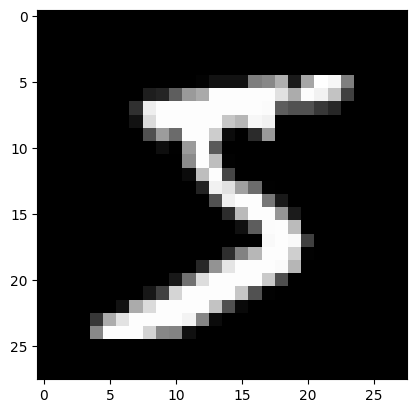

model prediction
5
encoded


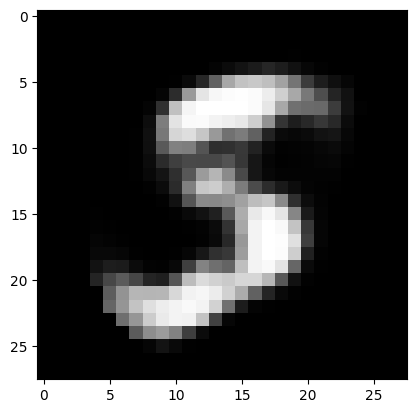

truncated


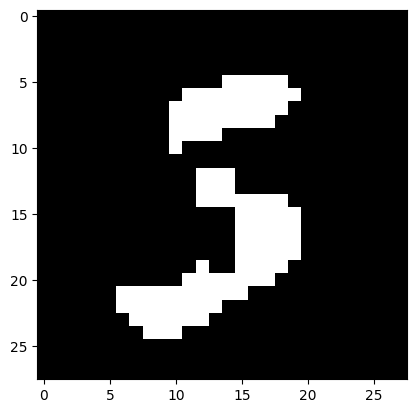

thresholded truncation


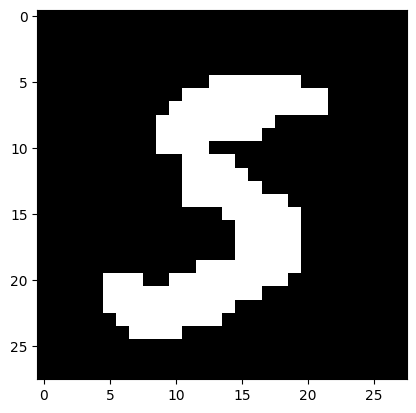

thresholded truncation x5


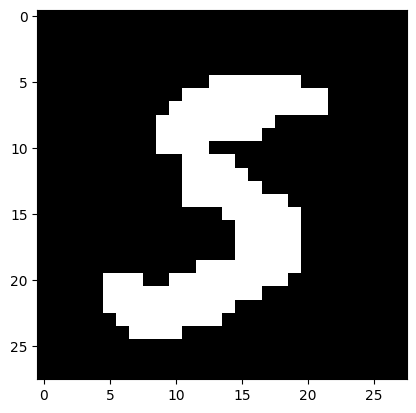

model encoded prediction
5

model predicted same on actual and encoded



actual


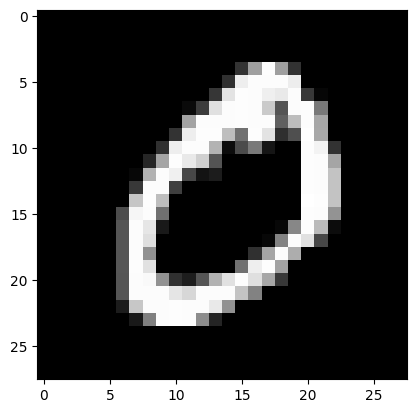

model prediction
0
encoded


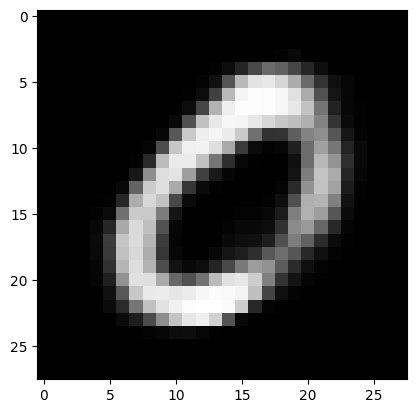

truncated


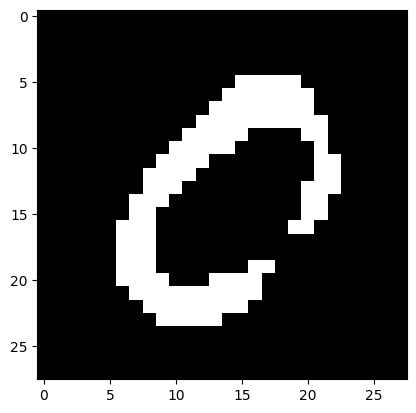

thresholded truncation


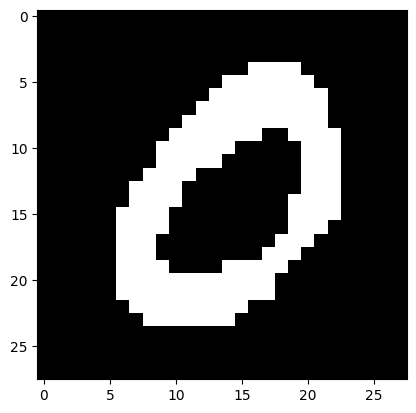

thresholded truncation x5


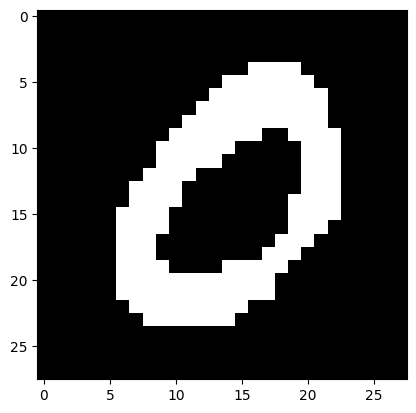

model encoded prediction
0

model predicted same on actual and encoded



actual


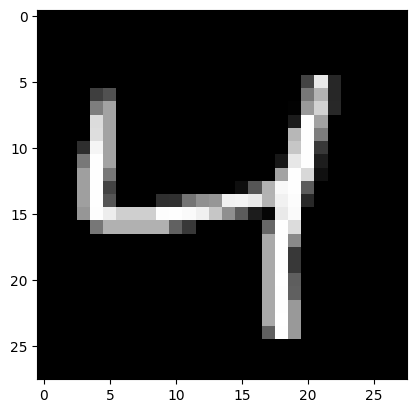

model prediction
4
encoded


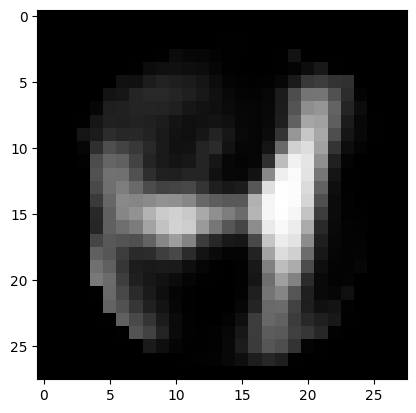

truncated


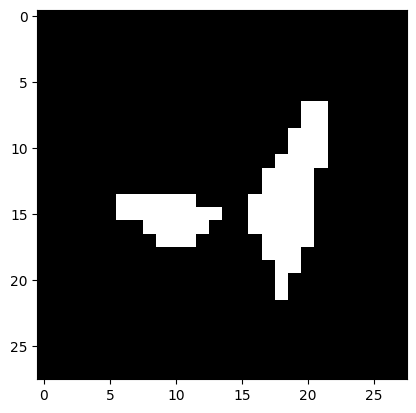

thresholded truncation


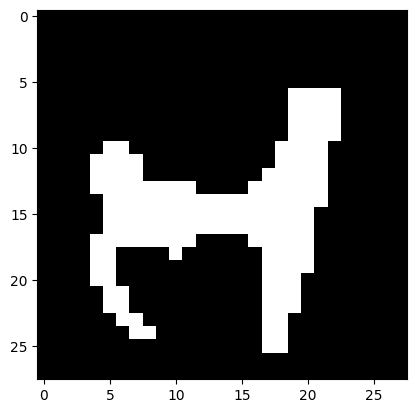

thresholded truncation x5


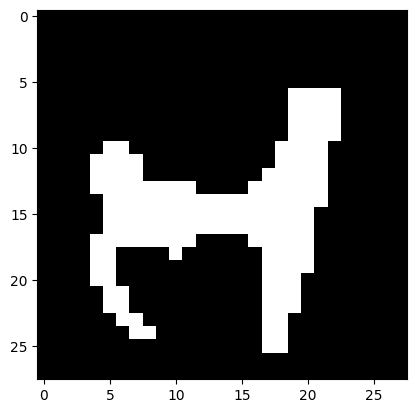

model encoded prediction
4

model predicted same on actual and encoded



actual


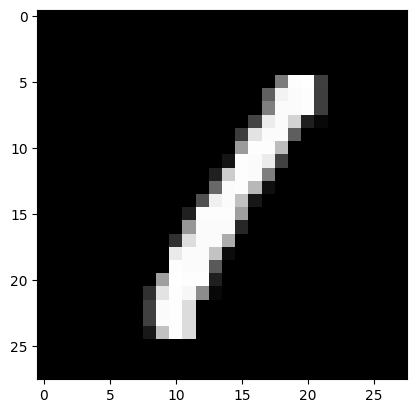

model prediction
1
encoded


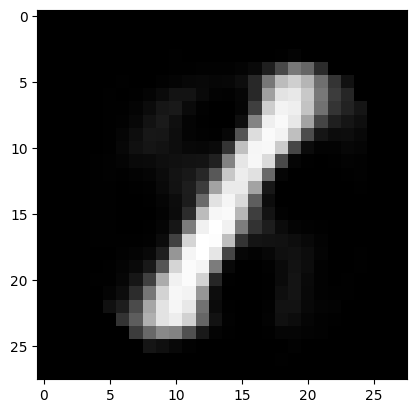

truncated


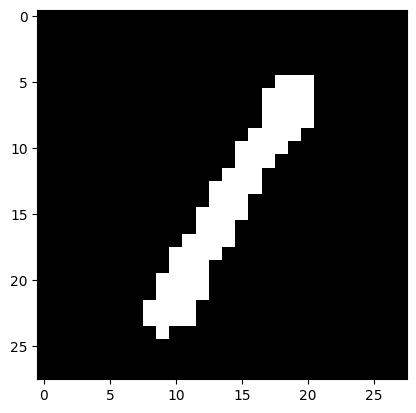

thresholded truncation


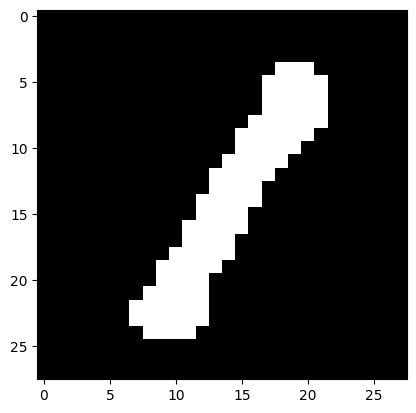

thresholded truncation x5


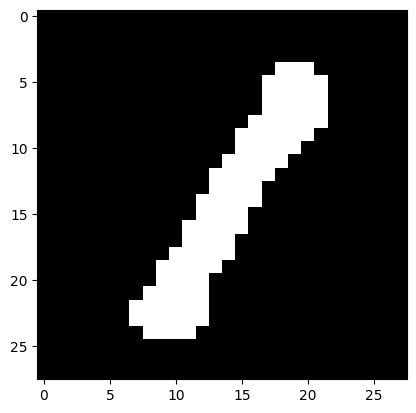

model encoded prediction
1

model predicted same on actual and encoded



actual


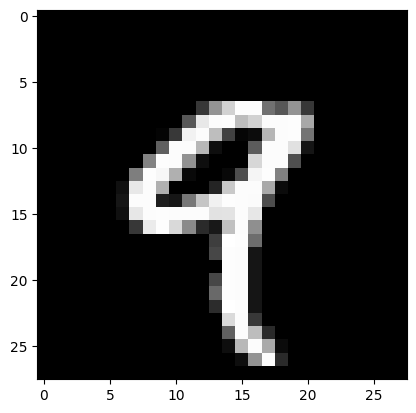

model prediction
9
encoded


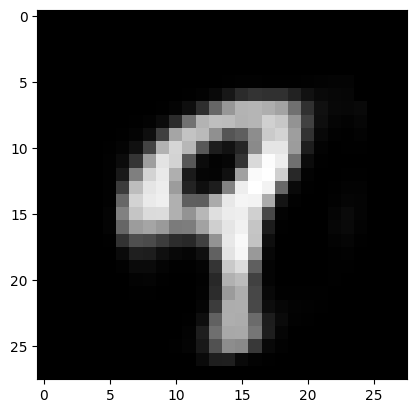

truncated


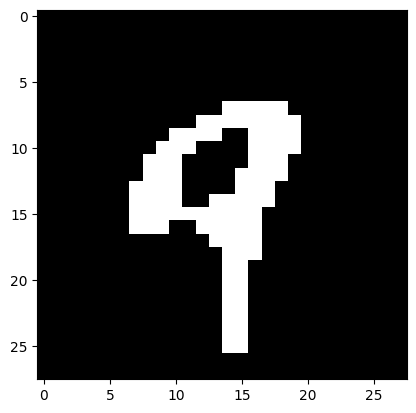

thresholded truncation


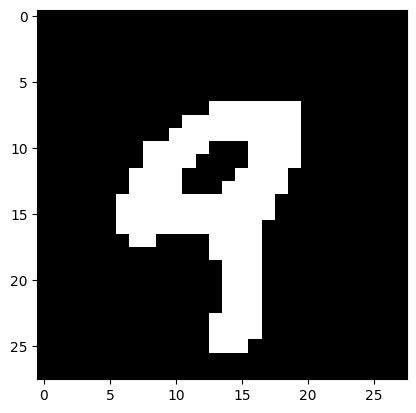

thresholded truncation x5


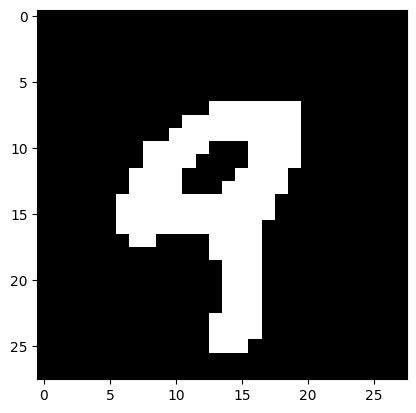

model encoded prediction
9

model predicted same on actual and encoded



actual


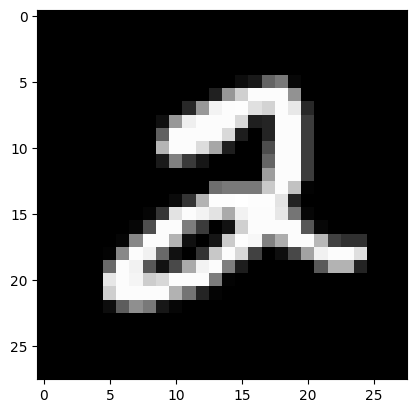

model prediction
2
encoded


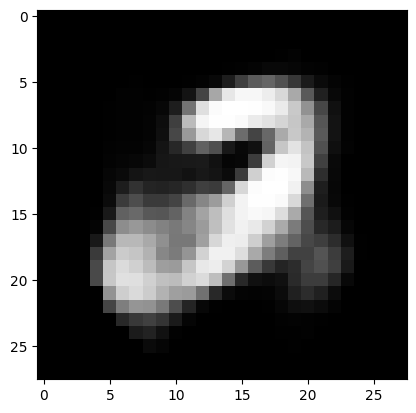

truncated


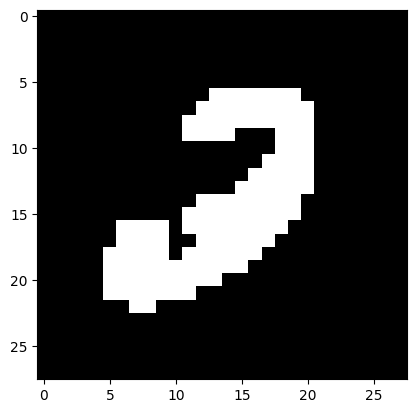

thresholded truncation


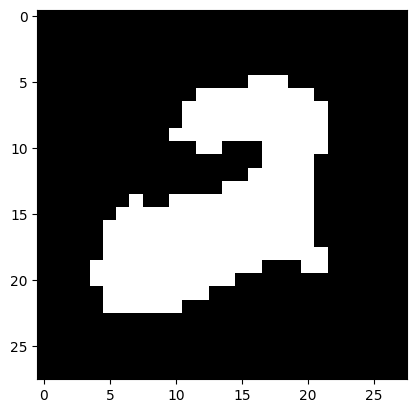

thresholded truncation x5


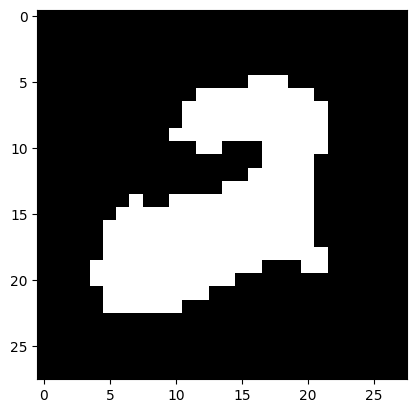

model encoded prediction
2

model predicted same on actual and encoded



actual


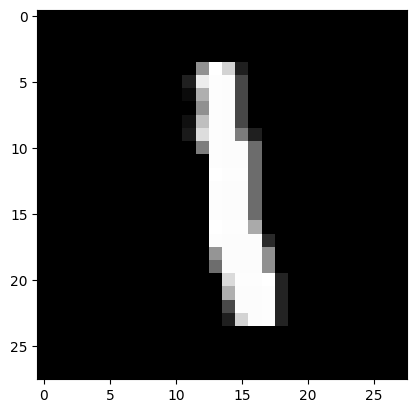

model prediction
1
encoded


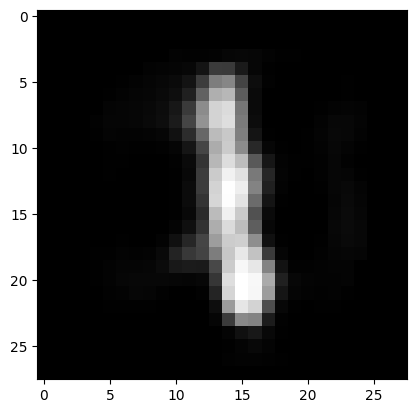

truncated


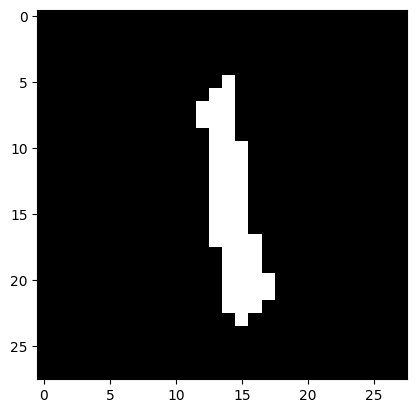

thresholded truncation


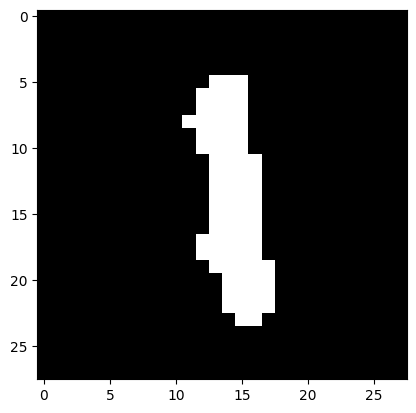

thresholded truncation x5


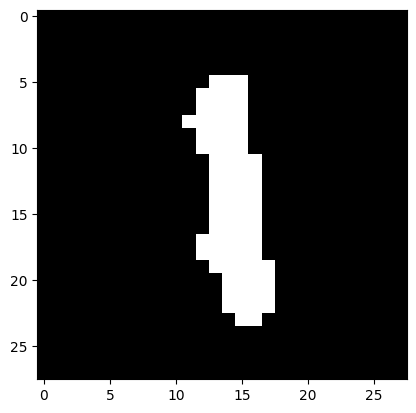

model encoded prediction
1

model predicted same on actual and encoded



actual


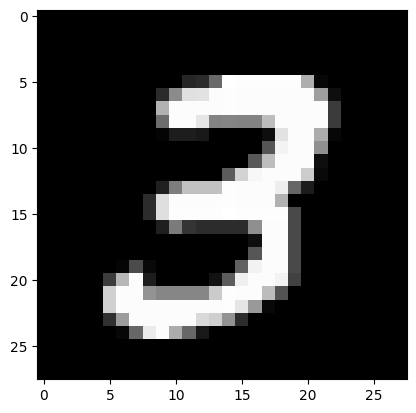

model prediction
3
encoded


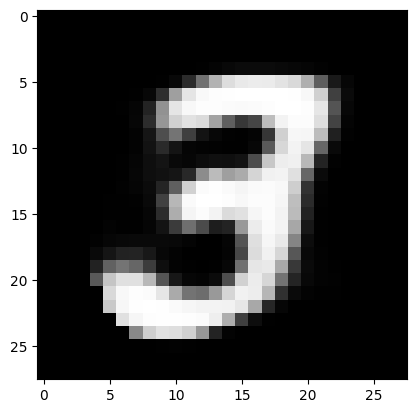

truncated


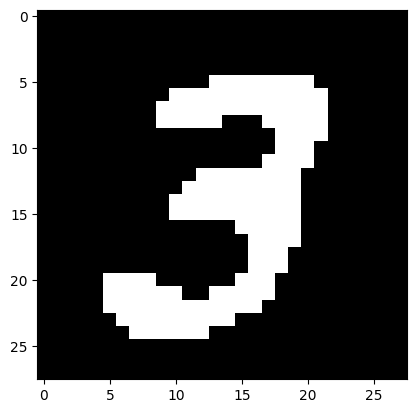

thresholded truncation


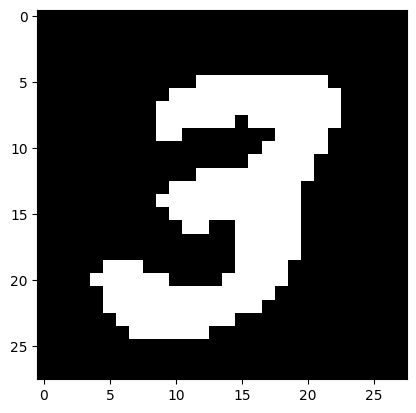

thresholded truncation x5


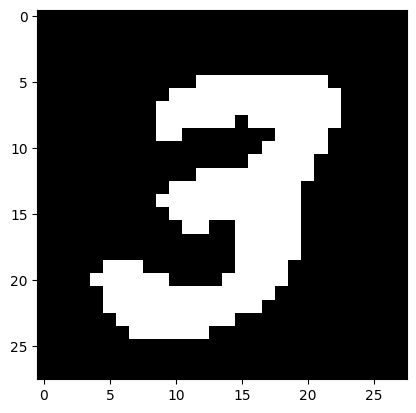

model encoded prediction
3

model predicted same on actual and encoded



actual


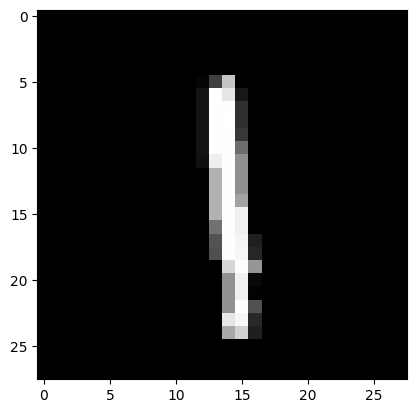

model prediction
1
encoded


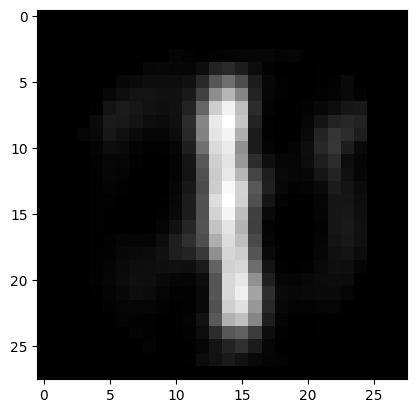

truncated


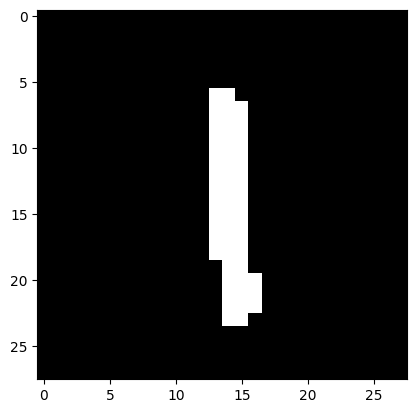

thresholded truncation


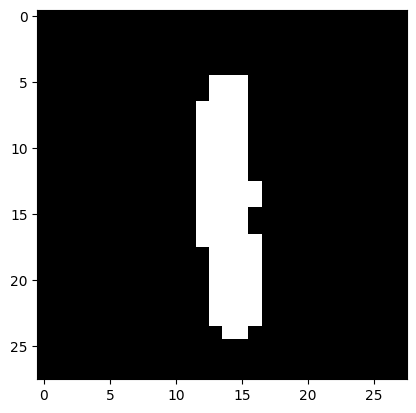

thresholded truncation x5


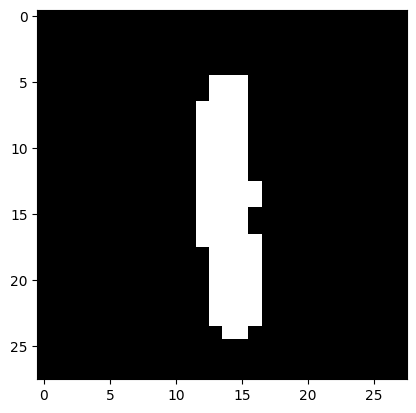

model encoded prediction
1

model predicted same on actual and encoded



actual


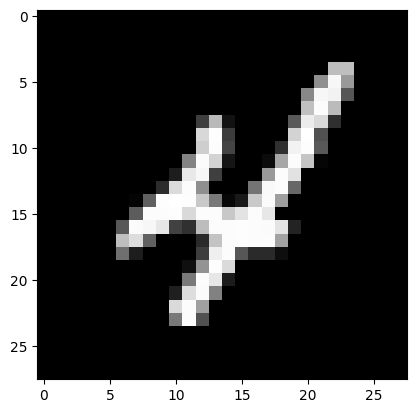

model prediction
4
encoded


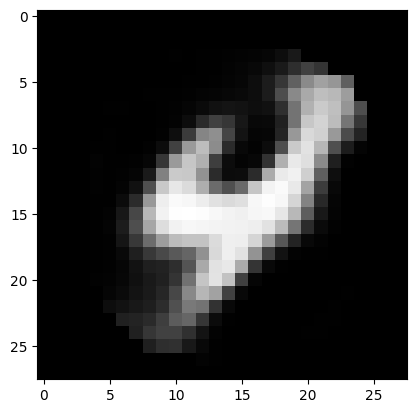

truncated


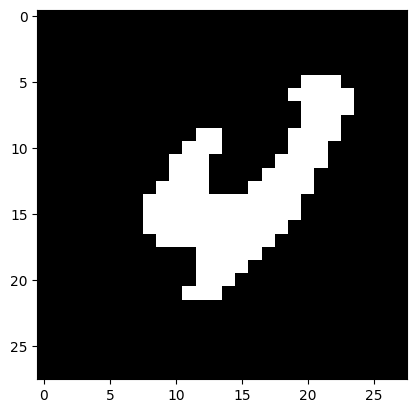

thresholded truncation


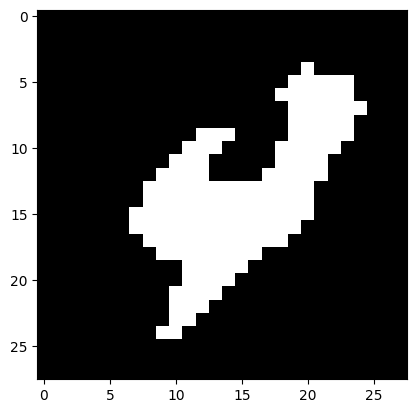

thresholded truncation x5


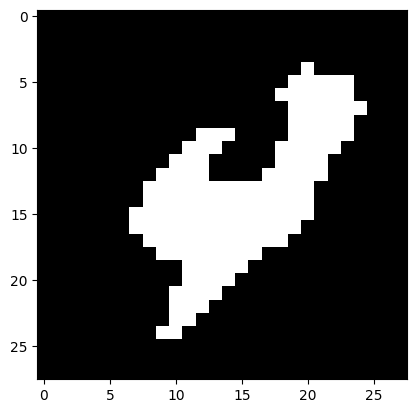

model encoded prediction
4

model predicted same on actual and encoded



actual


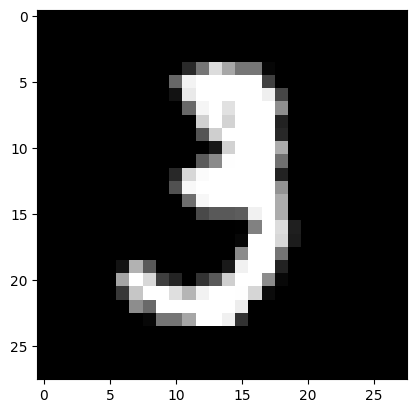

model prediction
3
encoded


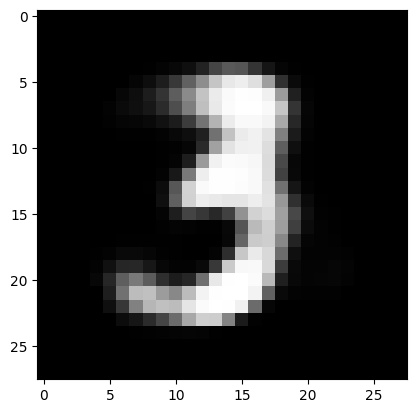

truncated


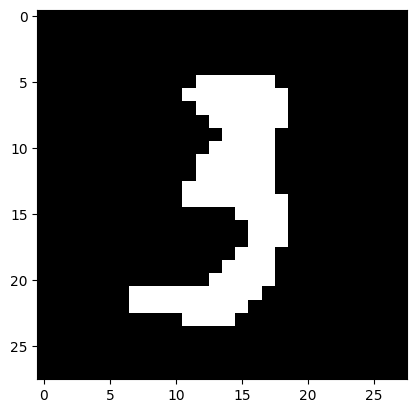

thresholded truncation


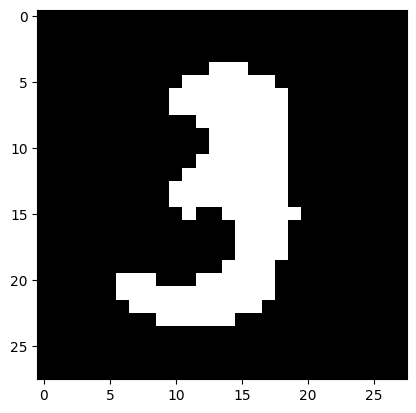

thresholded truncation x5


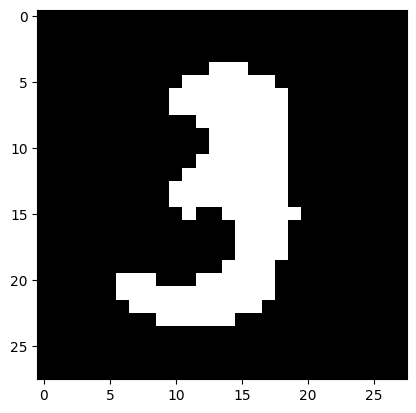

model encoded prediction
3

model predicted same on actual and encoded



actual


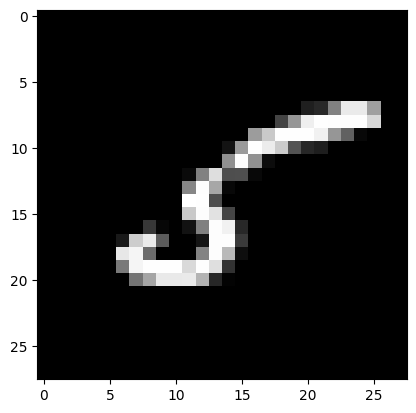

model prediction
5
encoded


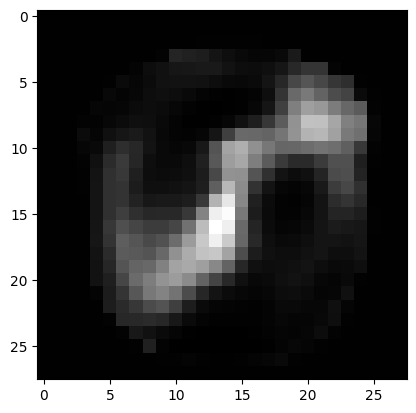

truncated


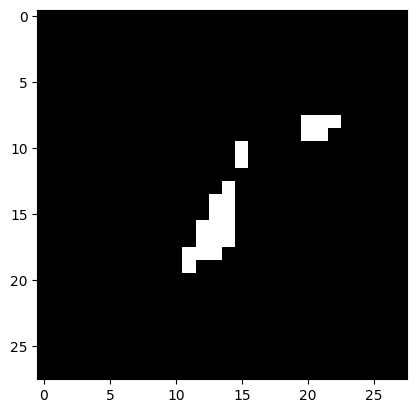

thresholded truncation


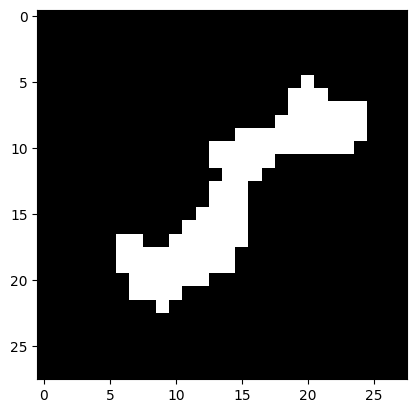

thresholded truncation x5


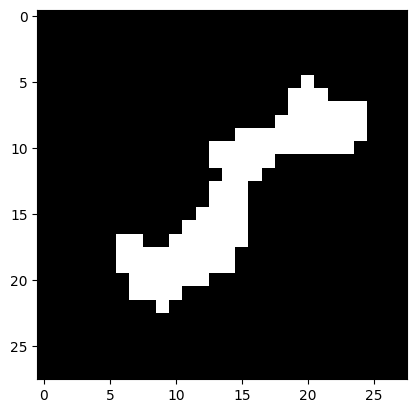

model encoded prediction
5

model predicted same on actual and encoded



actual


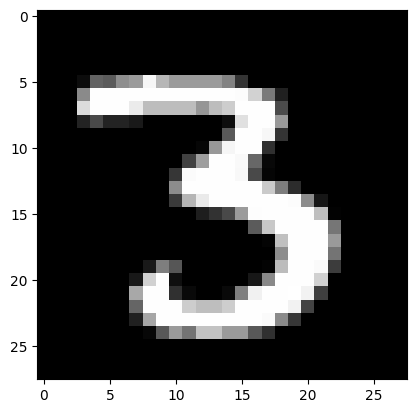

model prediction
3
encoded


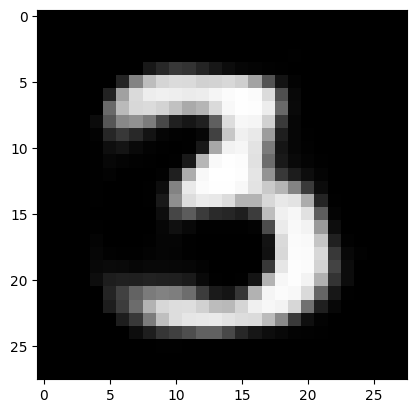

truncated


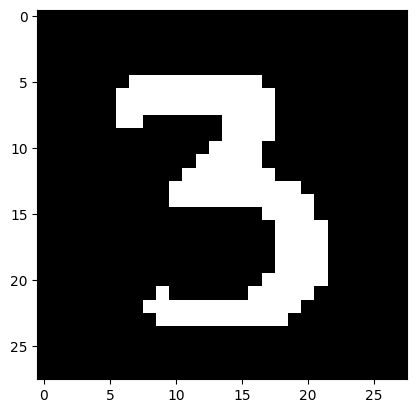

thresholded truncation


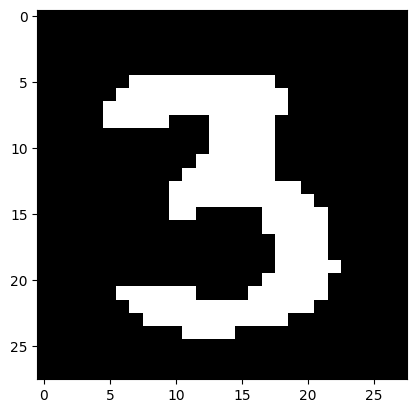

thresholded truncation x5


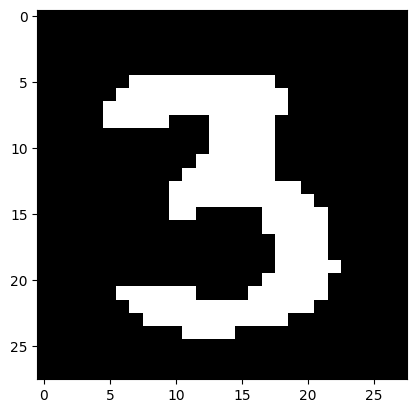

model encoded prediction
3

model predicted same on actual and encoded



actual


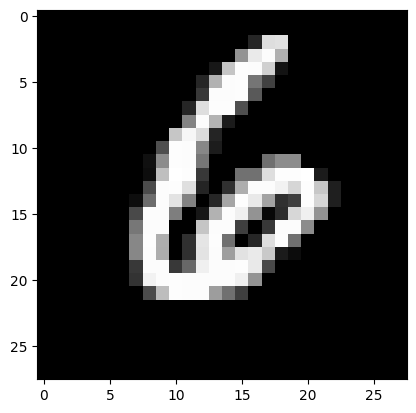

model prediction
6
encoded


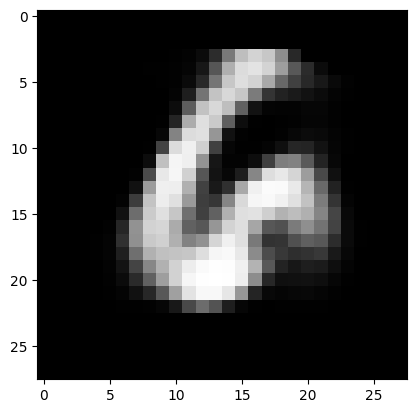

truncated


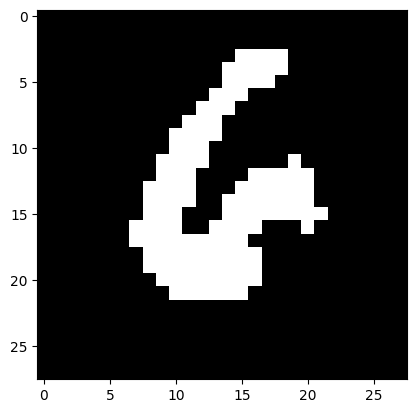

thresholded truncation


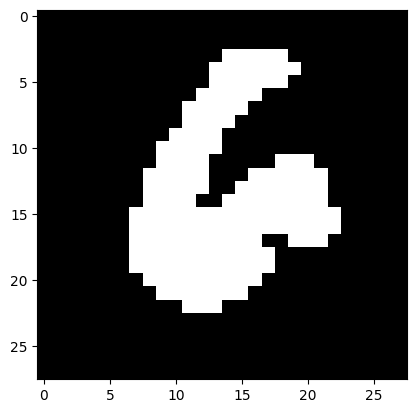

thresholded truncation x5


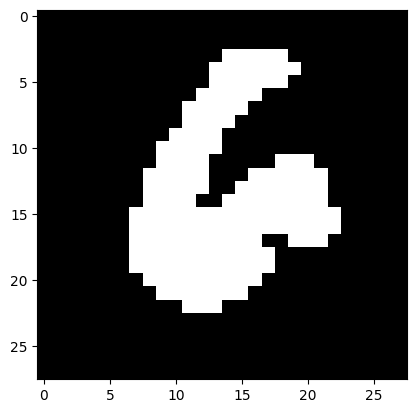

model encoded prediction
6

model predicted same on actual and encoded



actual


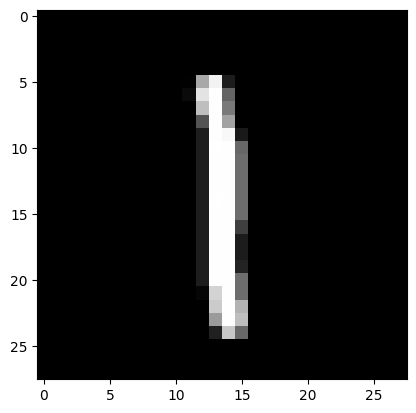

model prediction
1
encoded


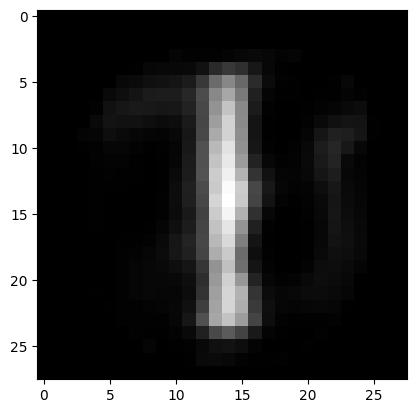

truncated


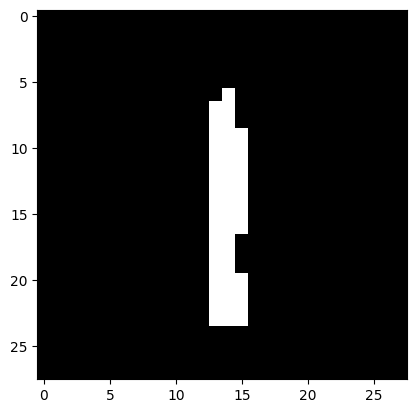

thresholded truncation


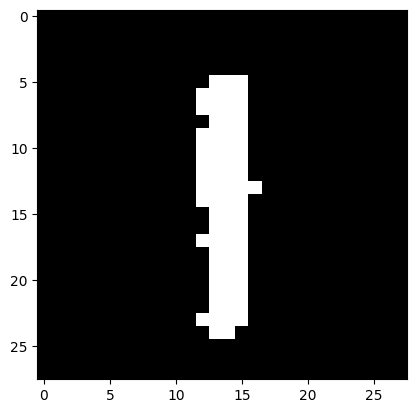

thresholded truncation x5


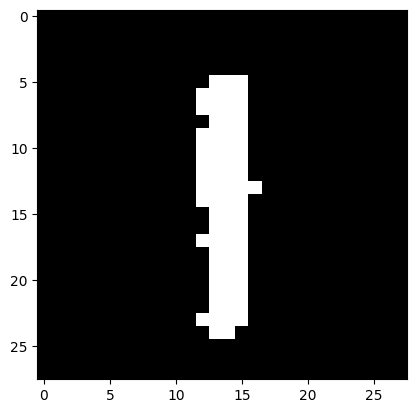

model encoded prediction
1

model predicted same on actual and encoded



actual


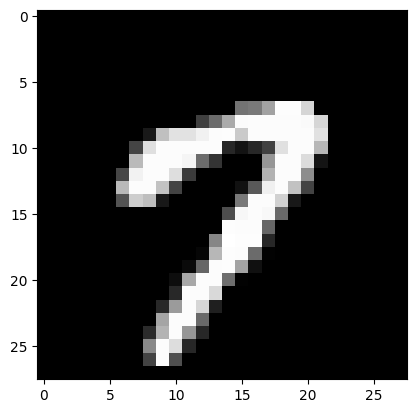

model prediction
7
encoded


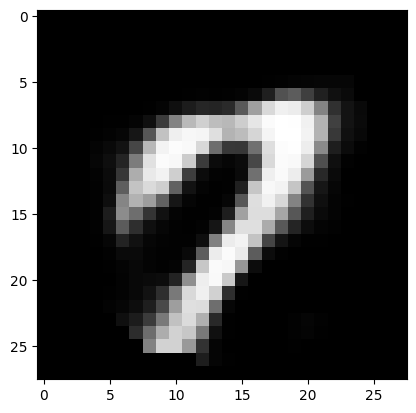

truncated


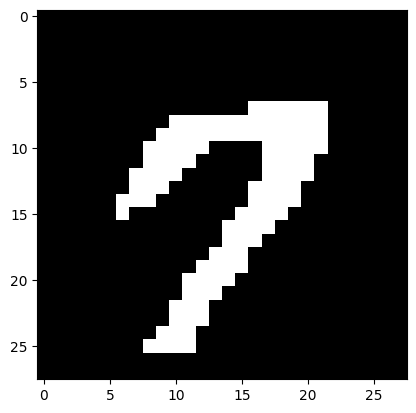

thresholded truncation


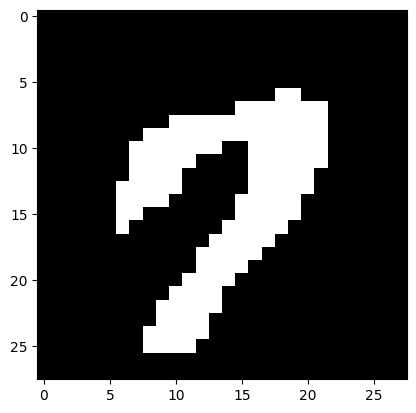

thresholded truncation x5


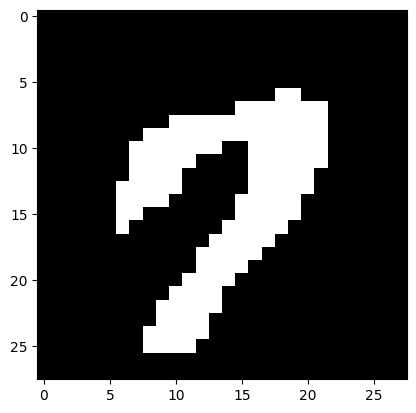

model encoded prediction
7

model predicted same on actual and encoded



actual


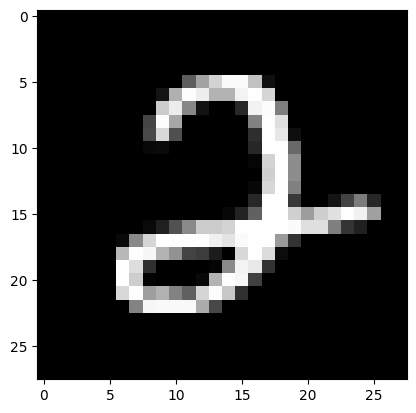

model prediction
2
encoded


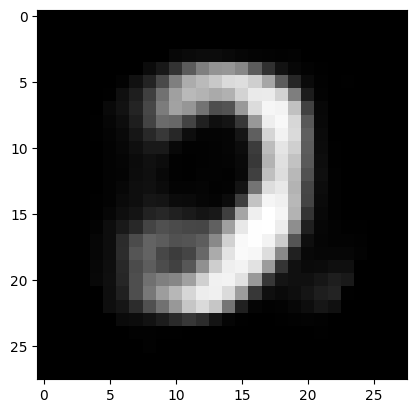

truncated


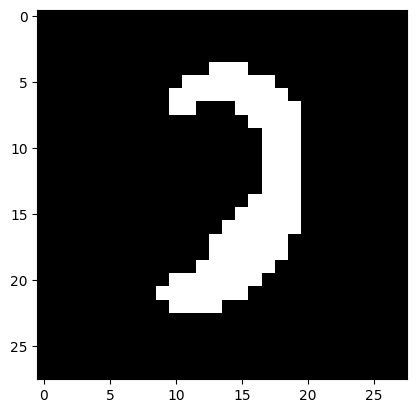

thresholded truncation


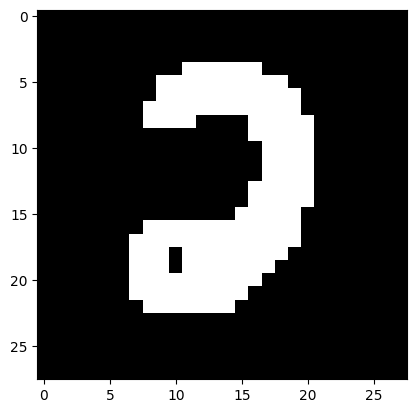

thresholded truncation x5


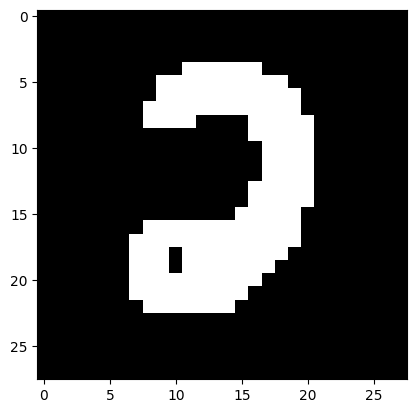

model encoded prediction
2

model predicted same on actual and encoded



actual


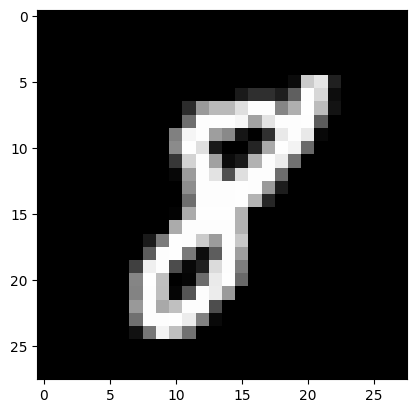

model prediction
8
encoded


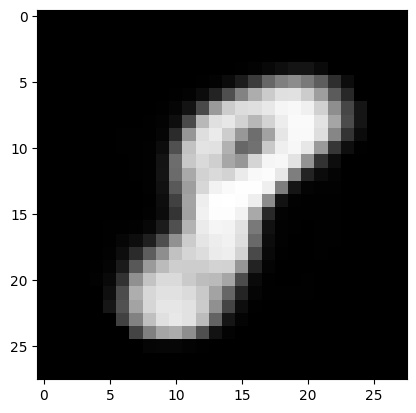

truncated


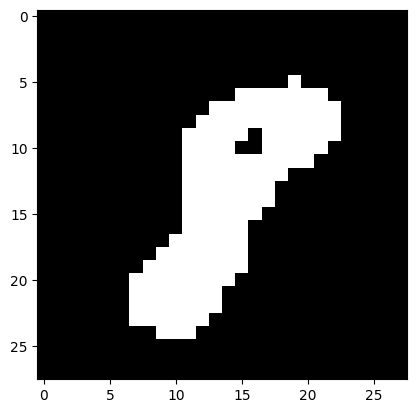

thresholded truncation


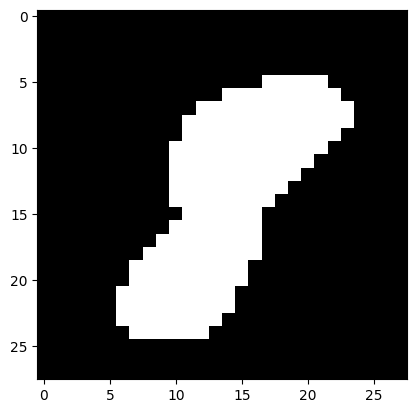

thresholded truncation x5


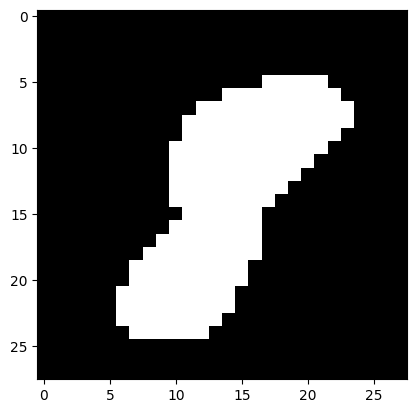

model encoded prediction
8

model predicted same on actual and encoded



actual


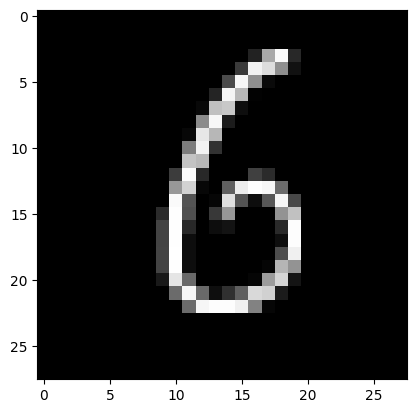

model prediction
6
encoded


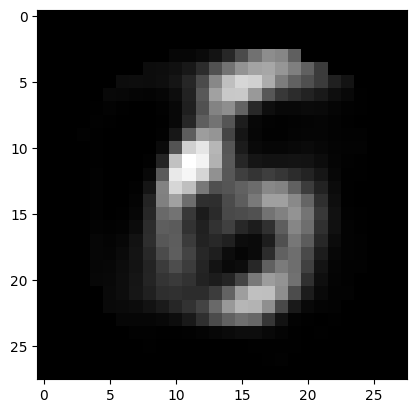

truncated


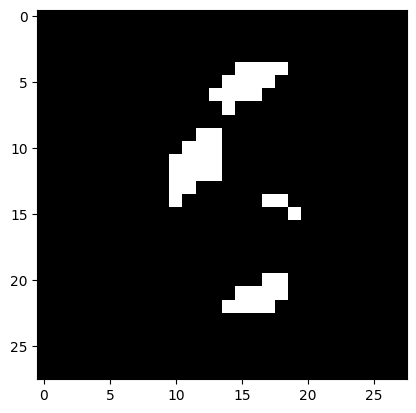

thresholded truncation


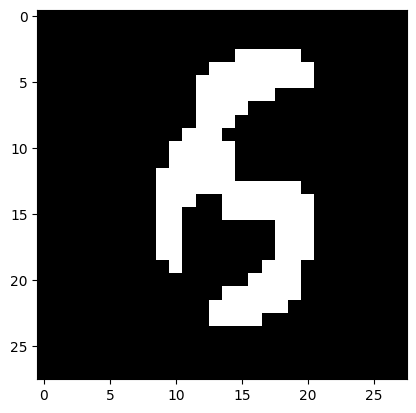

thresholded truncation x5


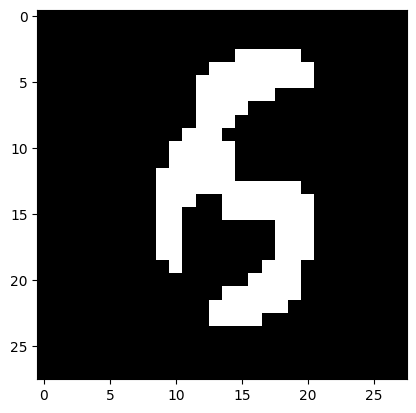

model encoded prediction
6

model predicted same on actual and encoded



actual


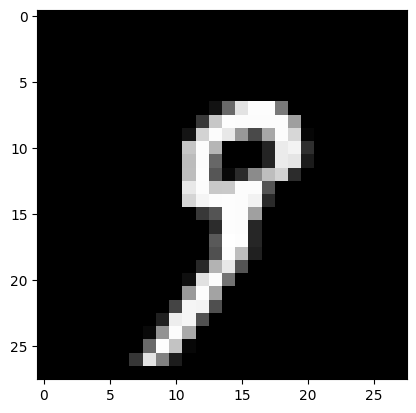

model prediction
9
encoded


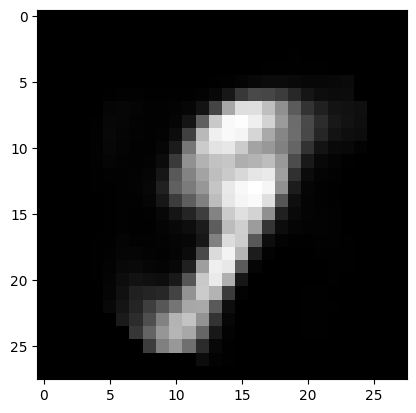

truncated


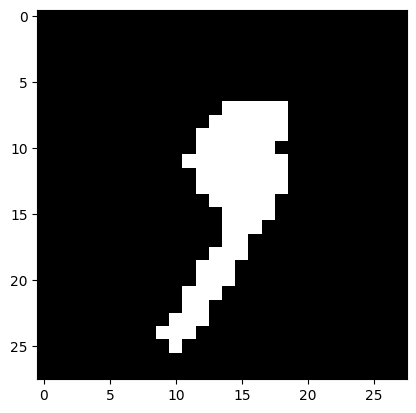

thresholded truncation


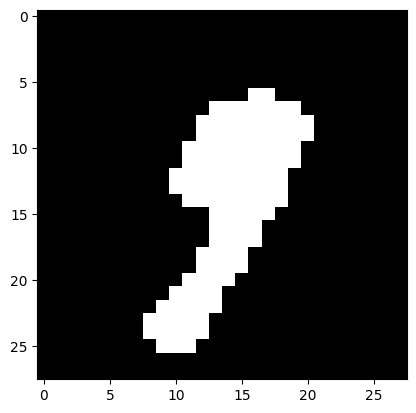

thresholded truncation x5


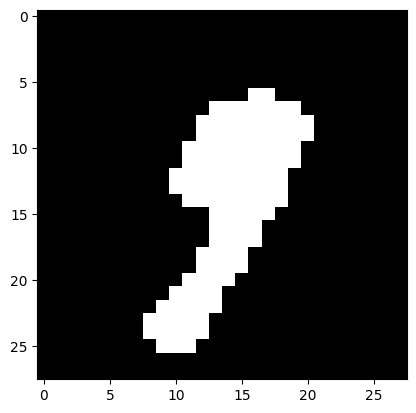

model encoded prediction
9

model predicted same on actual and encoded



actual


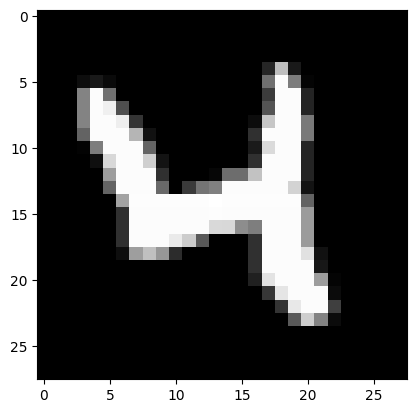

model prediction
4
encoded


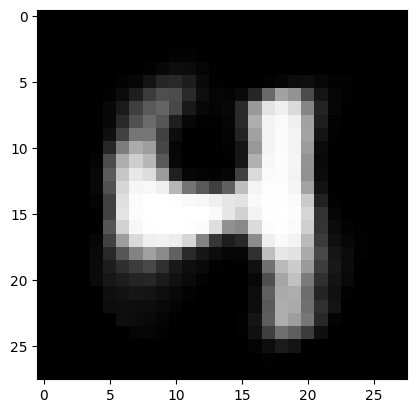

truncated


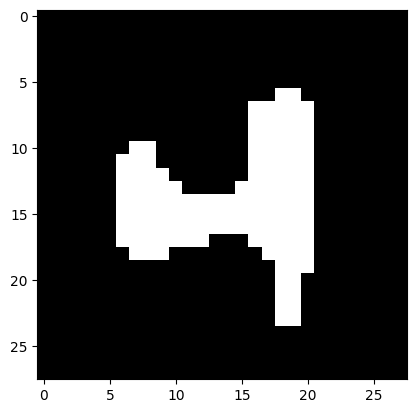

thresholded truncation


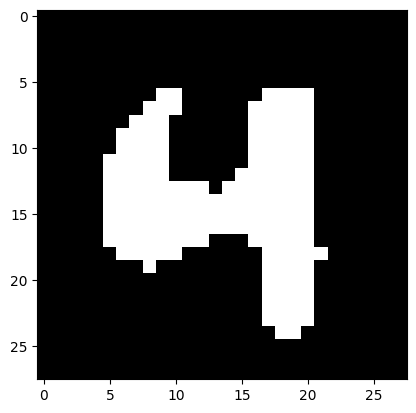

thresholded truncation x5


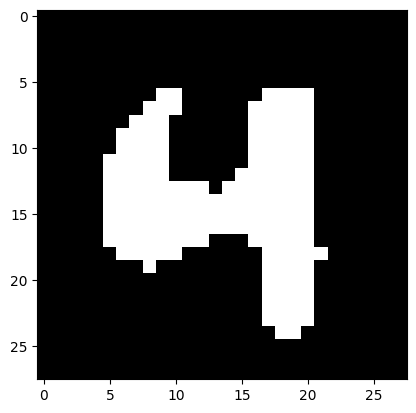

model encoded prediction
4

model predicted same on actual and encoded



actual


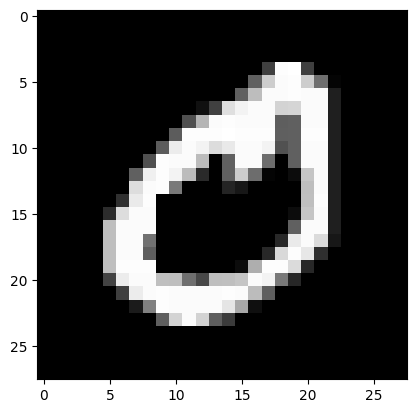

model prediction
0
encoded


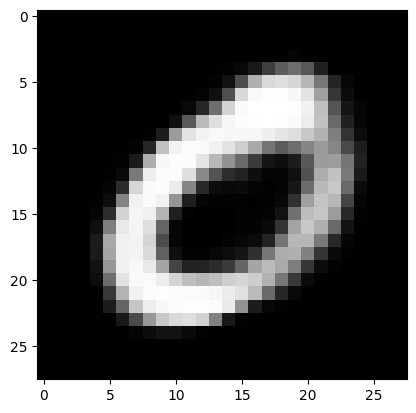

truncated


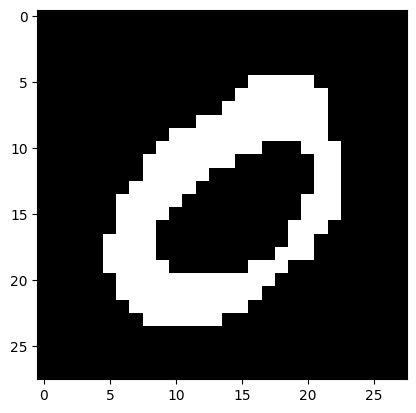

thresholded truncation


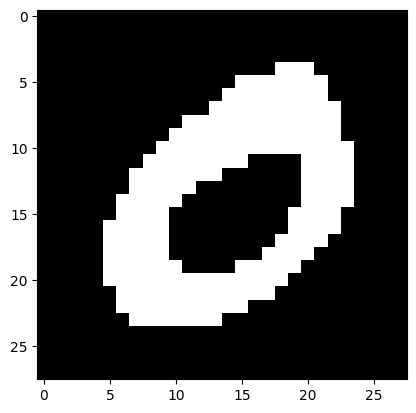

thresholded truncation x5


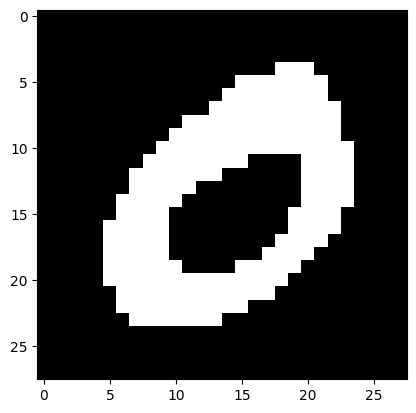

model encoded prediction
0

model predicted same on actual and encoded



actual


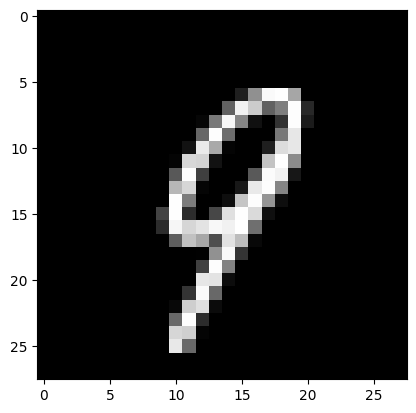

model prediction
9
encoded


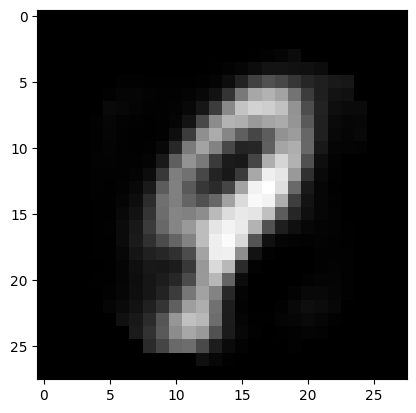

truncated


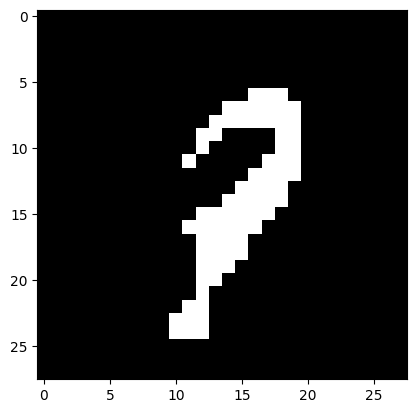

thresholded truncation


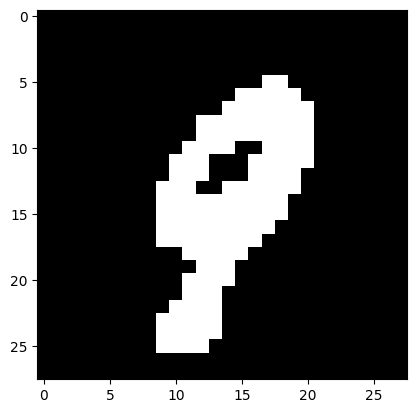

thresholded truncation x5


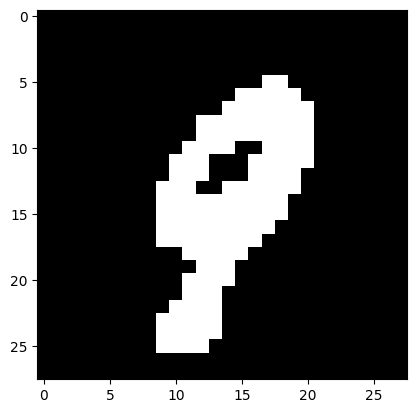

model encoded prediction
9

model predicted same on actual and encoded



actual


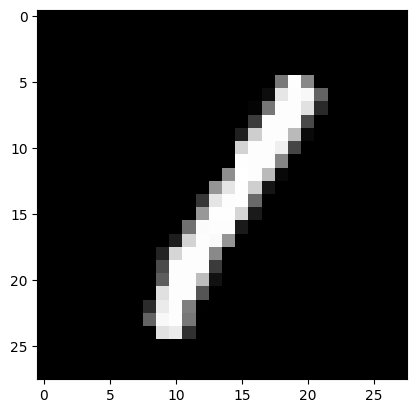

model prediction
1
encoded


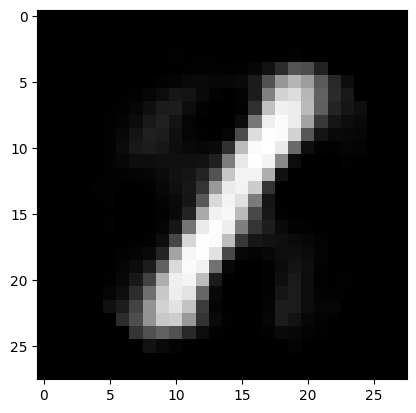

truncated


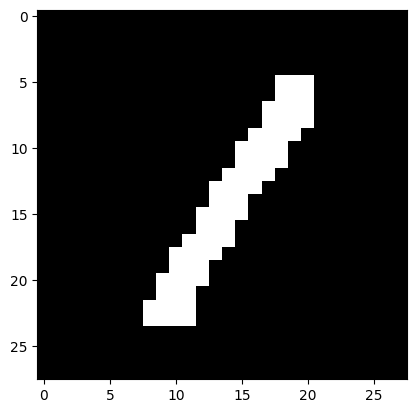

thresholded truncation


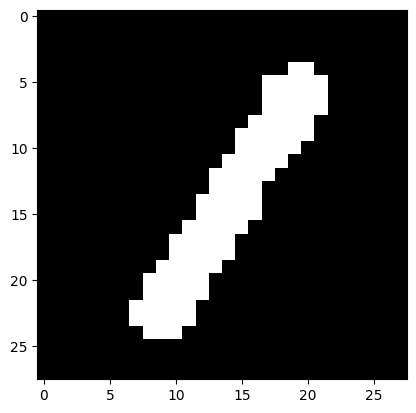

thresholded truncation x5


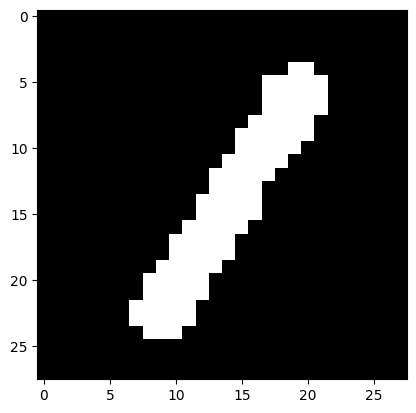

model encoded prediction
1

model predicted same on actual and encoded



actual


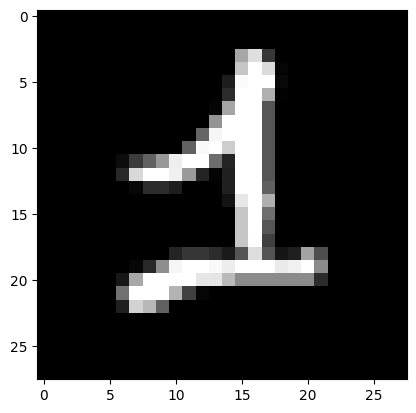

model prediction
3
encoded


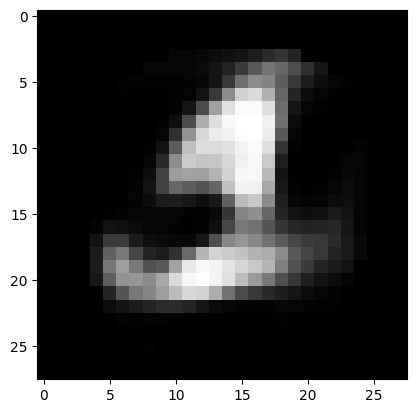

truncated


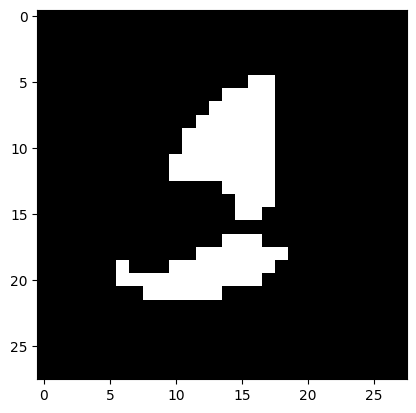

thresholded truncation


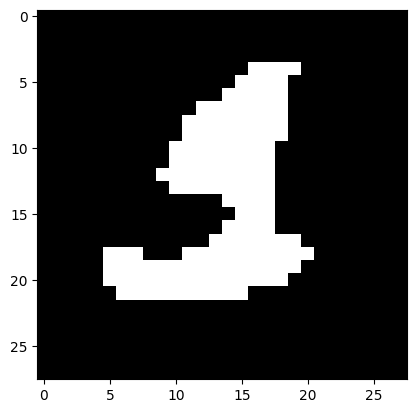

thresholded truncation x5


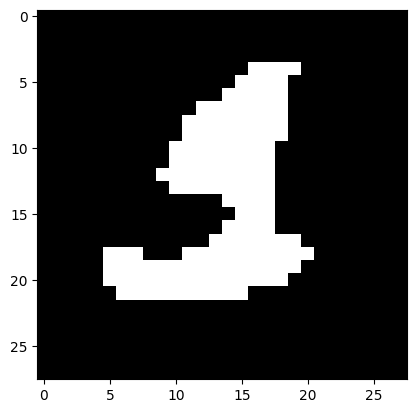

model encoded prediction
3

model predicted same on actual and encoded



actual


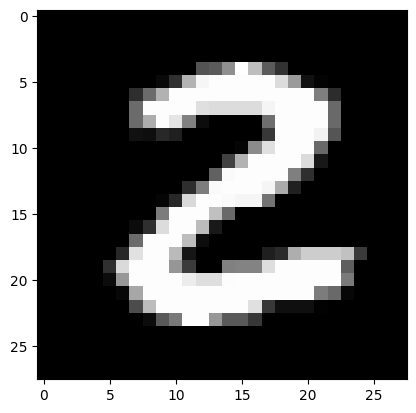

model prediction
2
encoded


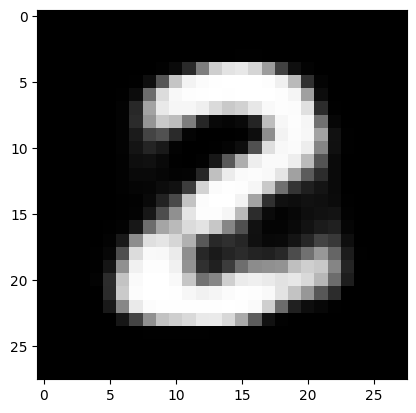

truncated


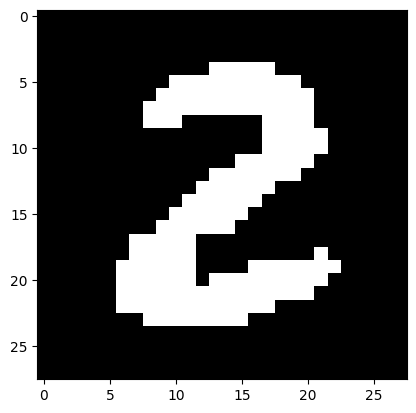

thresholded truncation


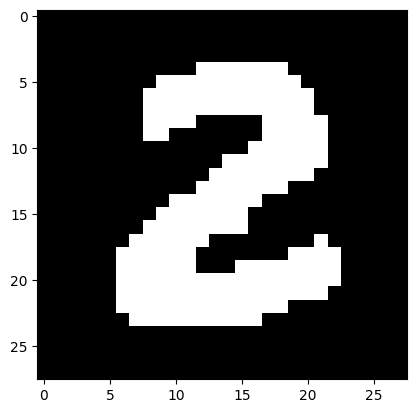

thresholded truncation x5


KeyboardInterrupt: 

In [ ]:
for i in range(30):
  print("actual")
  visualize(X_encode[i])
  print("model prediction")
  print(net.predict_sample(X_encode[i]))
  print("encoded")
  visualize(encoder.forward(X_encode[i]))
  print("truncated")
  truncated_encoding = np.round(encoder.forward(X_encode[i]))
  visualize(truncated_encoding)
  print("thresholded truncation")
  threshold = np.minimum(np.round(encoder.forward(X_encode[i]) * 2), 1)
  visualize(threshold)
  print("thresholded truncation x5")
  threshold2 = np.minimum(np.round(encoder.forward(X_encode[i]) * 2), 1)
  visualize(threshold2)
  print("model encoded prediction")
  print(net.predict_sample(encoder.forward(X_encode[i])))
  print()
  if net.predict_sample(encoder.forward(X_encode[i])) == net.predict_sample(X_encode[i]):
    print("model predicted same on actual and encoded")
  print()
  print()
  print()

In [ ]:
for i in range(30):
  print("actual")
  visualize(X_encode_test[i])
  print("model prediction")
  print(net.predict_sample(X_encode_test[i]))
  print("encoded")
  visualize(encoder.forward(X_encode_test[i]))
  print("truncated")
  truncated_encoding = np.round(encoder.forward(X_encode_test[i]))
  visualize(truncated_encoding)
  print("thresholded truncation")
  threshold = np.minimum(np.round(encoder.forward(X_encode_test[i]) * 2), 1)
  visualize(threshold)
  print("model encoded prediction")
  print(net.predict_sample(encoder.forward(X_encode_test[i])))
  print()
  if net.predict_sample(encoder.forward(X_encode_test[i])) == net.predict_sample(X_encode_test[i]):
    print("model predicted same on actual and encoded")
  print()
  print()
  print()